# **Practical session n°7** : Learning-to-Rank and Re-identification

**Part I:**

Several problems fall under the label "[learning-to-rank](https://link.springer.com/content/pdf/10.1007/978-3-642-15880-3_20.pdf)." One example is sorting a given list of labels (e.g. URL of websites) by relevance to an input query. This problem is referred to as *label ranking*.\
 In another scenario, input objects (e.g. images) should be sorted wrt a given criterion (e.g. 'foggy' or 'snowy'). Terms like *object ranking* and *learning to order things* are often used to describe this situation. In both cases, the learning is based on sorted samples, such as pairs of ordered images.

In this practical session, we illustrate the latter scenario using very simple synthetic images. All images consist of a mixture of a disc and a variable number of rectangles of different shapes. The goal is to sort the images based on the pixel intensity on the disc. To achieve this, we work in a standard context where we have pairs of ordered images. Using these pairs, we will train a neural network to construct a real-valued "ranking function" (*ranker*) whose outputs enable the sorting of images.

**Exercise #1:** Problem Construction

The following cells enable you to:
- generate a dataset on your drive (train+val and test),
- define a dataset that provides pairs of images and a comparison based on the criterion of disc intensity ("0" if the disc is more intense in the first image, "1" otherwise),
- visualize an initial batch.

In [1]:
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler

import matplotlib.pyplot as plt
import copy
from random import randint, choice



In [4]:
!git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 355 (delta 109), reused 106 (delta 87), pack-reused 210
Receiving objects: 100% (355/355), 46.92 MiB | 29.64 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [10]:
# imports from a git repo

#os.chdir('ml-student/TP7')

#from archis import *
from utile_tp7_partI import *
#from train_and_test import *

root = r"/content"

In [8]:
!ls

TP7_partI.ipynb  utile_tp7_partI.py


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
dir_trainval = join(root, r"train")
generate_dataset(dir_trainval, size_dataset=10000)

dir_test = join(root, r"test")
generate_dataset(dir_test, size_dataset=2000)

In [13]:
# Retrieving target values

# Image paths:
dir_images_trainval = os.path.join(dir_trainval, 'images')
dir_images_test = os.path.join(dir_test, 'images')

# Target values for train+val
label_dict_path_trainval = os.path.join(dir_trainval, 'labels_synthese.pickle')
with open(label_dict_path_trainval, 'rb') as handle:
    label_dict_trainval = pickle.load(handle)

# Target values for test
label_dict_path_test = os.path.join(dir_test, 'labels_synthese.pickle')
with open(label_dict_path_test, 'rb') as handle:
    label_dict_test = pickle.load(handle)

# Splitting train / val (8000/2000)
all_image_names = np.array(ls(dir_images_trainval))

train_indices = list(range(0, 8000))
names_train = all_image_names[train_indices]
val_indices = list(range(8000, 10000))
names_val = all_image_names[val_indices]
names_test = ls(dir_images_test)

# Note: for random splitting, use sklearn.model_selection.train_test_split as tts

In [ ]:
# Just in case:
# from shutil import rmtree
# rmtree(dir_test)

In [14]:
# Data Augmentation
class SuperFlip(object):
    """
    The 8 transformations
    generated by R(Pi/2) and vertical symmetry/axis
    """
    def __init__(self, num_transforms):
        self.num_transforms = num_transforms

    def __call__(self, image):
        # Note: Ideally, torch.randint should be used here...
        n = randint(0, self.num_transforms)
        if n == 1:
            image = image.flip([1])
        elif n == 2:
            image = image.flip([2])
        elif n == 3:
            image = image.transpose(1, 2)
        elif n == 4:
            image = image.transpose(1, 2).flip([1])
        elif n == 5:
            image = image.transpose(1, 2).flip([2])
        elif n == 6:
            image = image.flip([1, 2])
        elif n == 7:
            image = image.transpose(1, 2).flip([1, 2])
        return image

super_flip_transform = SuperFlip(8)

transforms = {
    'train': super_flip_transform,
    'val': None,
    'test': None
}

In [15]:
# Dataset Construction:
def oracle(name0, name1, data_dict):
    # Load the data:
    y0 = data_dict[name0]['y']
    y1 = data_dict[name1]['y']

    # Determine the comparison:
    compa = 0 if y1 < y0 else 1
    return compa

class DatasetOrderedPairs(torch.utils.data.Dataset):
    def __init__(self, images_dir, data_dict, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.imgs = ls(images_dir)
        self.data_dict = data_dict

    def __getitem__(self, idx):
        name0 = self.imgs[idx]
        name1 = choice(self.imgs)
        label = oracle(name0, name1, self.data_dict)

        # Get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 = torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array(label)).long(), name0, name1   # -1 if no class 0

    def __len__(self):
        return len(self.imgs)

In [16]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [17]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

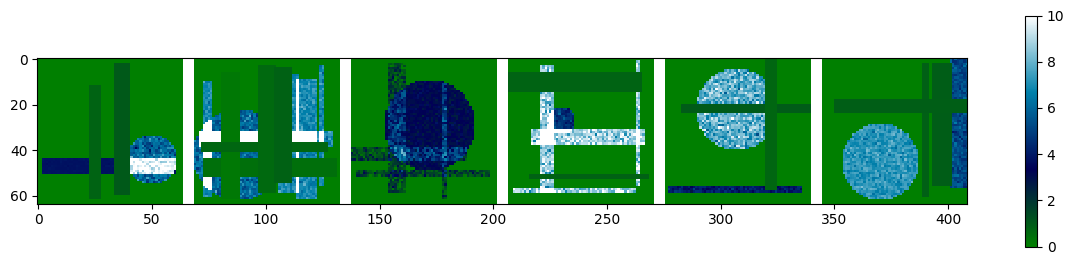

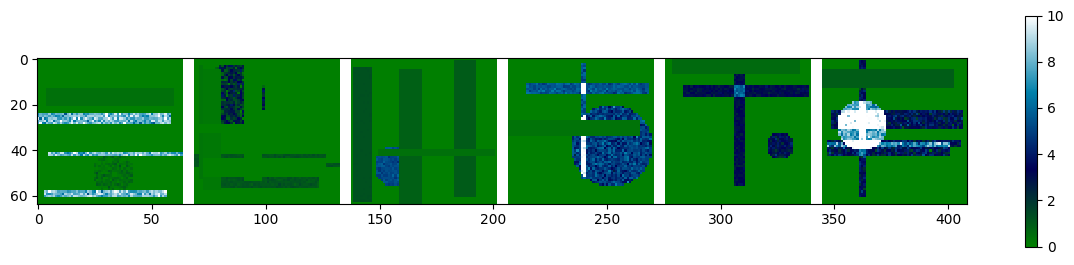

tensor([0, 0, 1, 1, 0, 1])


In [18]:
# Visualisation

img1, img2, labels, _, _ = next(iter(dataloaders['viz']))

fig0 = plt.figure(0, figsize=(15, 3))
voir_batch2D(img1, nx = 8, fig = fig0, k=0, min_scale=0,max_scale=10)
fig1 = plt.figure(1, figsize=(15, 3))
voir_batch2D(img2, nx = 8, fig = fig1, k=0, min_scale=0,max_scale=10)

print(labels)


**Q0** How is done the separation between training and validation done here?

In [ ]:
randomly

**Q1** What is the role of *super_flip*? And that of the *oracle* function?

In [ ]:
super_flip: Augmentation
oracle: compare intensities to create labels of pairs

**Q2** Are all pairs of images equally easy to order?

**Exercise #2:** Siamese Learning

During training, batches of image pairs are compared. Basic siamese network training involves passing each image in the pair independently through the model and penalizing the model when the outputs are arranged in the wrong order.

The simplest way to do this is to consider the positive part of the difference between the outputs. This is what the following cost function does:

In [20]:
# Hinge Loss function

def label_to_sgn(label):  # 0 -> 1  and 1 -> -1
    sgn = torch.where(label == 0, 1, -1)
    return sgn

class HingeLoss(torch.nn.Module):
    def __init__(self, margin=0.1):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label):
        sgn = label_to_sgn(label)
        diff = sgn * (output1 - output0)

        loss = torch.relu(diff + self.margin).mean()
        return loss

**Q1** Write the training loop and run it for 20 epochs. Keep track of the successive accuracies.

In [21]:
num_epochs = 20
channels = 1

# With a ResNet18
from torchvision.models import resnet18
model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Init the new conv layer
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")


device = torch.device("cuda:0")
model = model.to(device)

criterion = HingeLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.002 )

# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=="train"):
              out1=model(img1)
              out2=model(img2)
              loss=criterion(out1,out2,labels.to(torch.float32).unsqueeze(dim=1))
            if phase=="train":
              loss.backward()
              optimizer.step()
            preds=torch.cat((out1.unsqueeze(0),out2.unsqueeze(0))).argmax(0).squeeze()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0624 Acc: 0.7302


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0541 Acc: 0.7665
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0480 Acc: 0.8004


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0475 Acc: 0.8000
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0424 Acc: 0.8279


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0393 Acc: 0.8395
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0384 Acc: 0.8426


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0379 Acc: 0.8465
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0367 Acc: 0.8489


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0389 Acc: 0.8395
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0332 Acc: 0.8639


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0320 Acc: 0.8705
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0332 Acc: 0.8665


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0329 Acc: 0.8670
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0319 Acc: 0.8728


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0305 Acc: 0.8780
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0325 Acc: 0.8690


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0338 Acc: 0.8665
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0304 Acc: 0.8794


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0286 Acc: 0.8845
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0305 Acc: 0.8770


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0300 Acc: 0.8880
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0296 Acc: 0.8819


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0307 Acc: 0.8745
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0285 Acc: 0.8854


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0265 Acc: 0.8980
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0291 Acc: 0.8830


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0249 Acc: 0.9065
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0282 Acc: 0.8890


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0247 Acc: 0.9025
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0281 Acc: 0.8868


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0268 Acc: 0.8920
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0267 Acc: 0.8944


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0259 Acc: 0.9005
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0263 Acc: 0.8966


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0251 Acc: 0.9010
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0256 Acc: 0.8968


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0240 Acc: 0.9100
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0244 Acc: 0.9042


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0258 Acc: 0.8960


**Q3** Check the learning curve.

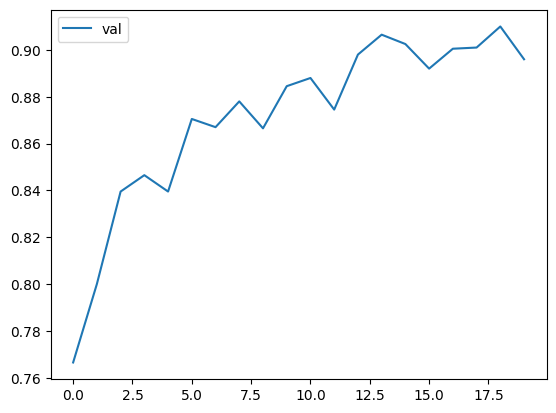

In [43]:
plt.plot(val_accs,label="val")
#plt.plot(train_accs,label='train')
plt.legend()


**Q4** Interprete the following scatterplot:

Text(0, 0.5, '$\\hat{y}$')

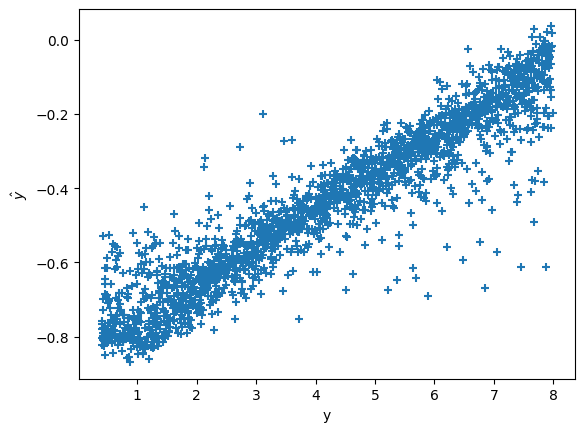

In [44]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Q5** Calculate the Spearman and Kendall rank correlations. Which of the two is related to the accuracy measure?


In [46]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.4 MB/s eta 0:00:00


In [47]:
from torchmetrics import SpearmanCorrCoef
spearman = SpearmanCorrCoef()
ys = []
# outputs of the network:
yhats = []
# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)
    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)
    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)
ys = torch.tensor(ys)
yhats = torch.tensor(yhats)
spearman(ys,yhats)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


tensor(0.9400)

In [51]:
from torchmetrics.regression import KendallRankCorrCoef

kendall = KendallRankCorrCoef()
kendall(ys,yhats)

tensor(0.8018)

**Q6** We extend the training to 50 epochs. Load the following checkpoint, revisit questions 4 and 5 with this model, and provide comments.

In [52]:
os.chdir('/content')
! wget https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
PATH_checkpoint = './WUuEwrxaf65_vySRhNAbepk'

--2023-12-22 08:48:44--  https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134182874 (128M) [application/octet-stream]
Saving to: ‘WUuEwrxaf65_vySRhNAbepk’

WUuEwrxaf65_vySRhNA 100%[===================>] 127.97M  18.2MB/s    in 8.3s    

2023-12-22 08:48:54 (15.4 MB/s) - ‘WUuEwrxaf65_vySRhNAbepk’ saved [134182874/134182874]



**Q7** How would you improve performance?

Curriculum Learning:
- Seek more "challenging" pairs towards the end of training.

Optimization:
- Consider adding a learning rate scheduler.

Other Loss Functions:
- Explore RankNet loss.
- Explore Listnet Loss.

**Exercice #3** Curriculum Learning

One idea is to make the problem harder after an initial training phase. The following code allows you to retrieve a ResNet18 trained for 50 epochs, the optimizer, and the associated learning curve:

**Q1** Take the ResNet18 trained on 50 epochs. Continue training for an additional 20 epochs without changing the dataloader. Remember to store accuracies related to the validation set and outputs related to the test set.

In [59]:

model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.load_state_dict(torch.load(PATH_checkpoint)['model'])
optimizer.load_state_dict(torch.load(PATH_checkpoint)['optimizer'])

In [ ]:
torch.load(PATH_checkpoint)['val_accs']

In [60]:
model=model.to(device)

In [61]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']
num_epochs=20

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=="train"):
              out1=model(img1)
              out2=model(img2)
              loss=criterion(out1,out2,labels.to(torch.float32).unsqueeze(dim=1))
            if phase=="train":
              loss.backward()
              optimizer.step()
            preds=torch.cat((out1.unsqueeze(0),out2.unsqueeze(0))).argmax(0).squeeze()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)

Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9231


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9315
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0220 Acc: 0.9184


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0201 Acc: 0.9255
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0212 Acc: 0.9217


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0202 Acc: 0.9260
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0226 Acc: 0.9189


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0197 Acc: 0.9225
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0210 Acc: 0.9209


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0217 Acc: 0.9200
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0217 Acc: 0.9201


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0205 Acc: 0.9270
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0229 Acc: 0.9164


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0232 Acc: 0.9190
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0211 Acc: 0.9203


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0199 Acc: 0.9250
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0215 Acc: 0.9216


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0195 Acc: 0.9305
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0231 Acc: 0.9187


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0202 Acc: 0.9310
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0206 Acc: 0.9246


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0209 Acc: 0.9235
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0202 Acc: 0.9234


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0196 Acc: 0.9340
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0210 Acc: 0.9234


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9360
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0223 Acc: 0.9146


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0238 Acc: 0.9165
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0226 Acc: 0.9169


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0197 Acc: 0.9265
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 0.9265


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0191 Acc: 0.9325
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0226 Acc: 0.9180


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0178 Acc: 0.9380
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0220 Acc: 0.9201


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0193 Acc: 0.9240
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0231 Acc: 0.9171


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 0.9240
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0215 Acc: 0.9207


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0234 Acc: 0.9150


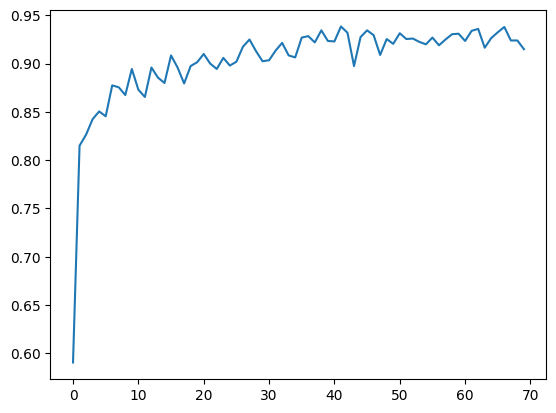

In [77]:
#plt.plot(torch.load(PATH_checkpoint)['train_accs']+train_accs)
plt.plot(torch.load(PATH_checkpoint)['val_accs']+val_accs)

**Q2** We will now continue training on pairs that are harder to order. For this purpose, we have the 'Dataset_finer_pairs' dataset below. Train for 20 epochs using this dataset (use epoch_ray = 1.).

In [63]:
def make_dic_ray(imgs, dic, ray):

  ys = np.array([dic[img]['y'] for img in imgs])
  imgs = np.array(imgs)
  dic_ray = {}
  for i,img in enumerate(imgs):
    y = ys[i]
    # on limite la paire à des disques proches en intensité
    dic_ray[img] = list(imgs[np.abs(ys - y) < ray])

  return dic_ray

class Dataset_finer_pairs(torch.utils.data.Dataset):
    def __init__(self, images_dir,  dic, transfo = None, ray=0.5):
        self.images_dir = images_dir
        self.transfo = transfo
        self.imgs = sorted(ls(images_dir))
        self.dic = dic
        self.dic_ray = make_dic_ray(self.imgs, dic, ray)

    def __getitem__(self,idx):

        name0 = self.imgs[idx]
        name1 = choice(self.dic_ray[name0])
        label = oracle(name0, name1, self.dic)


        #get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 =  torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)


        if self.transfo is not None:
            img0 = self.transfo(img0)
            img1 = self.transfo(img1)

        return img0, img1,  torch.from_numpy(np.array(label)).long(), name0, name1

    def __len__(self):
        return len(self.imgs)

In [100]:
# Dataset instantiation:
dataset_train = Dataset_finer_pairs(dir_images_trainval, label_dict_trainval, transforms['train'],ray=1.)
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [101]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

In [106]:
model_cur = resnet18(num_classes=1)
model_cur.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_cur.load_state_dict(torch.load(PATH_checkpoint)['model'])
model_cur=model_cur.to(device)
optimizer = optim.Adam(model_cur.parameters(), lr = 0.002 )
optimizer.load_state_dict(torch.load(PATH_checkpoint)['optimizer'])



In [ ]:
from tqdm import tqdm, notebook

train_accs_cur = []
val_accs_cur = []

phases = ['train', 'val']
num_epochs=20

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model_cur.train()  # Set model to training mode
        else:
            model_cur.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=="train"):
              out1=model_cur(img1)
              out2=model_cur(img2)
              loss=criterion(out1,out2,labels.to(torch.float32).unsqueeze(dim=1))
            if phase=="train":
              loss.backward()
              optimizer.step()
            preds=torch.cat((out1.unsqueeze(0),out2.unsqueeze(0))).argmax(0).squeeze()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs_cur.append(epoch_acc)

        if phase == 'val':
            val_accs_cur.append(epoch_acc)

Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0656 Acc: 0.7439


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0184 Acc: 0.9285
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0658 Acc: 0.7376


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0195 Acc: 0.9295
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0623 Acc: 0.7558


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0201 Acc: 0.9250
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0613 Acc: 0.7658


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0185 Acc: 0.9245
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0602 Acc: 0.7710


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0214 Acc: 0.9240
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0610 Acc: 0.7609


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0202 Acc: 0.9270
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0572 Acc: 0.7792


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0161 Acc: 0.9390
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0592 Acc: 0.7699


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0171 Acc: 0.9435
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

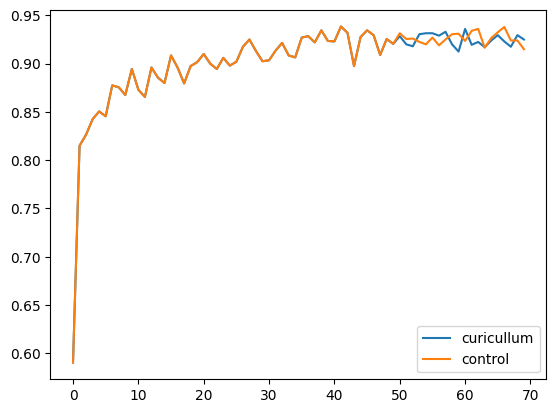

In [99]:
plt.plot(torch.load(PATH_checkpoint)['val_accs']+val_accs_cur,label='curicullum')
plt.plot(torch.load(PATH_checkpoint)['val_accs']+val_accs,label='control')
plt.legend()

**Q3** Why is the training accuracy lower than before? Compare the learning curves (validation accuracies) and the results on the test set. Discuss.

Text(0, 0.5, '$\\hat{y}$')

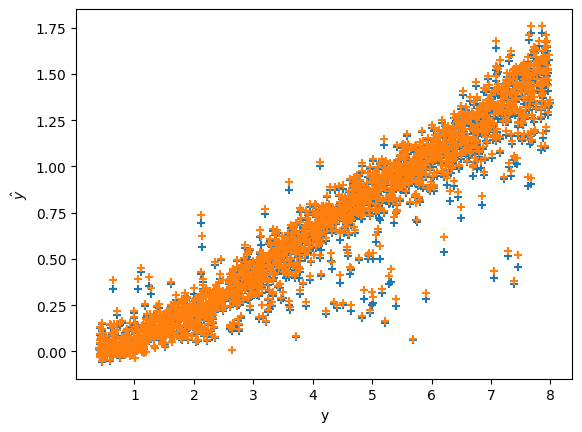

In [87]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model_cur.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

**Exercise #4** RankNet Loss (and ListNet Loss)

A milder version of the Hinge Loss has been widely used, particularly in search engine learning, known as the RankNet Loss.

This cost function is derived from a parametric probabilistic model, the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

In a general version, it is assumed that the outcome of a comparison (or match) between two objects "0" and "1" (or two teams) is random and depends on real values associated with the objects (the "team levels") as follows:
\begin{align}
P_0 = \dfrac{f(y_0)}{f(y_0) + f(y_1)}
\tag{1}
\end{align}
Where $P_0$ is the probability of choosing object "0" (or the first team winning), and $f$ is a strictly increasing function with positive values.

**Q1** In the case where $f(y) = e^{\sigma y}$, what do the choice probabilities depend on? Write the log-likelihood of the event "object $x$ is chosen."

**Q2** Derive an appropriate cost function for our ranking problem based on the given log-likelihood.

**Q3** Implement and compare over twenty epochs.